Loading expression data from C:/Users/sanis/OneDrive/Desktop/Sem 8/Genomic Data Analysis/project/data.csv...
Loaded data dimensions: (16278, 498)
Loading all TFs from C:/Users/sanis/OneDrive/Desktop/Sem 8/Genomic Data Analysis/project/all_tfs.csv...
Starting regression analysis...
Loading known TF-target relationships from C:/Users/sanis/OneDrive/Desktop/Sem 8/Genomic Data Analysis/project/known_tf_targets.csv...
Saved known_tf_target_relationships.png
Top target genes per TF:

CREB1:
  - NF1 (R²=0.657, Coef=0.811)
  - ZNF593 (R²=0.655, Coef=-0.810)
  - ZBTB11 (R²=0.626, Coef=0.791)
  - BRMS1 (R²=0.623, Coef=-0.789)
  - SMARCAD1 (R²=0.623, Coef=0.789)

FOXO1:
  - PAPPA (R²=0.480, Coef=0.693)
  - PTCHD1 (R²=0.460, Coef=0.678)
  - GFRA1 (R²=0.439, Coef=0.662)
  - MITF (R²=0.428, Coef=0.654)
  - DMD (R²=0.411, Coef=0.641)

HIF1A:
  - PRKAR2A (R²=0.476, Coef=0.690)
  - ITCH (R²=0.476, Coef=0.690)
  - XRN2 (R²=0.468, Coef=0.684)
  - KTN1 (R²=0.457, Coef=0.676)
  - FAM114A1 (R²=0.450, Coef=0

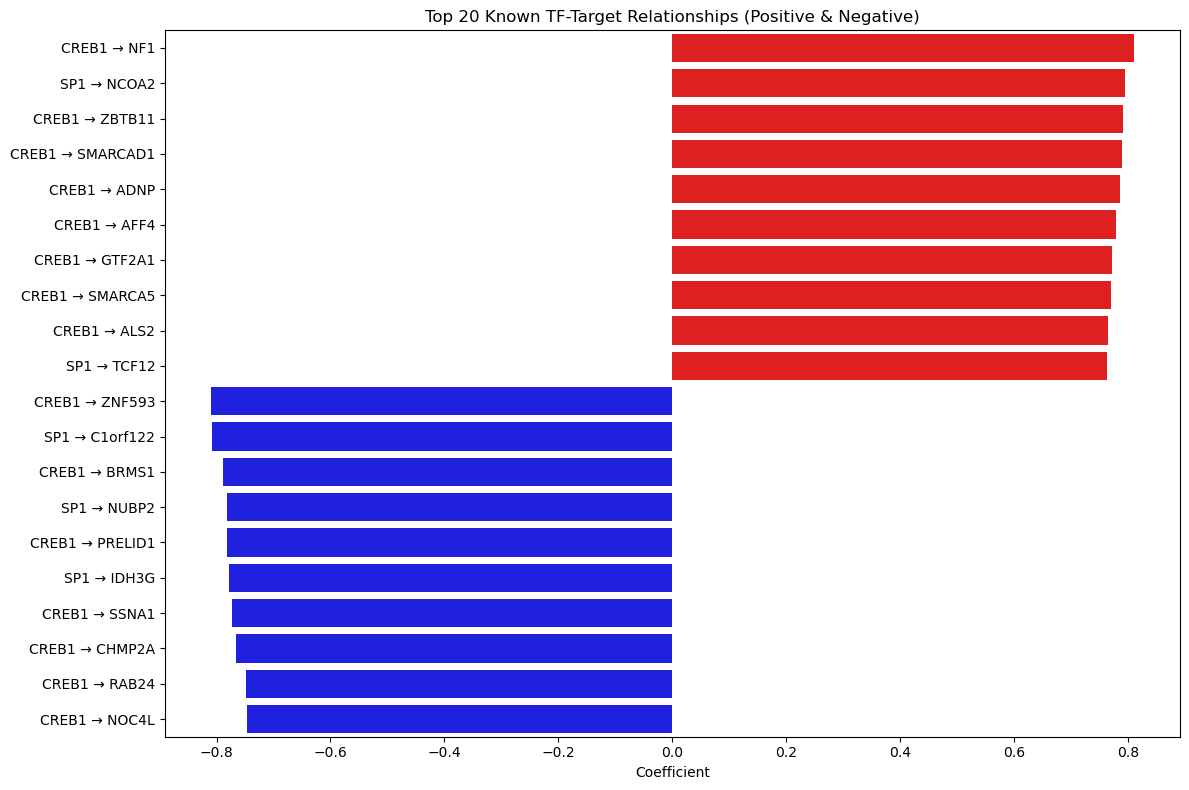

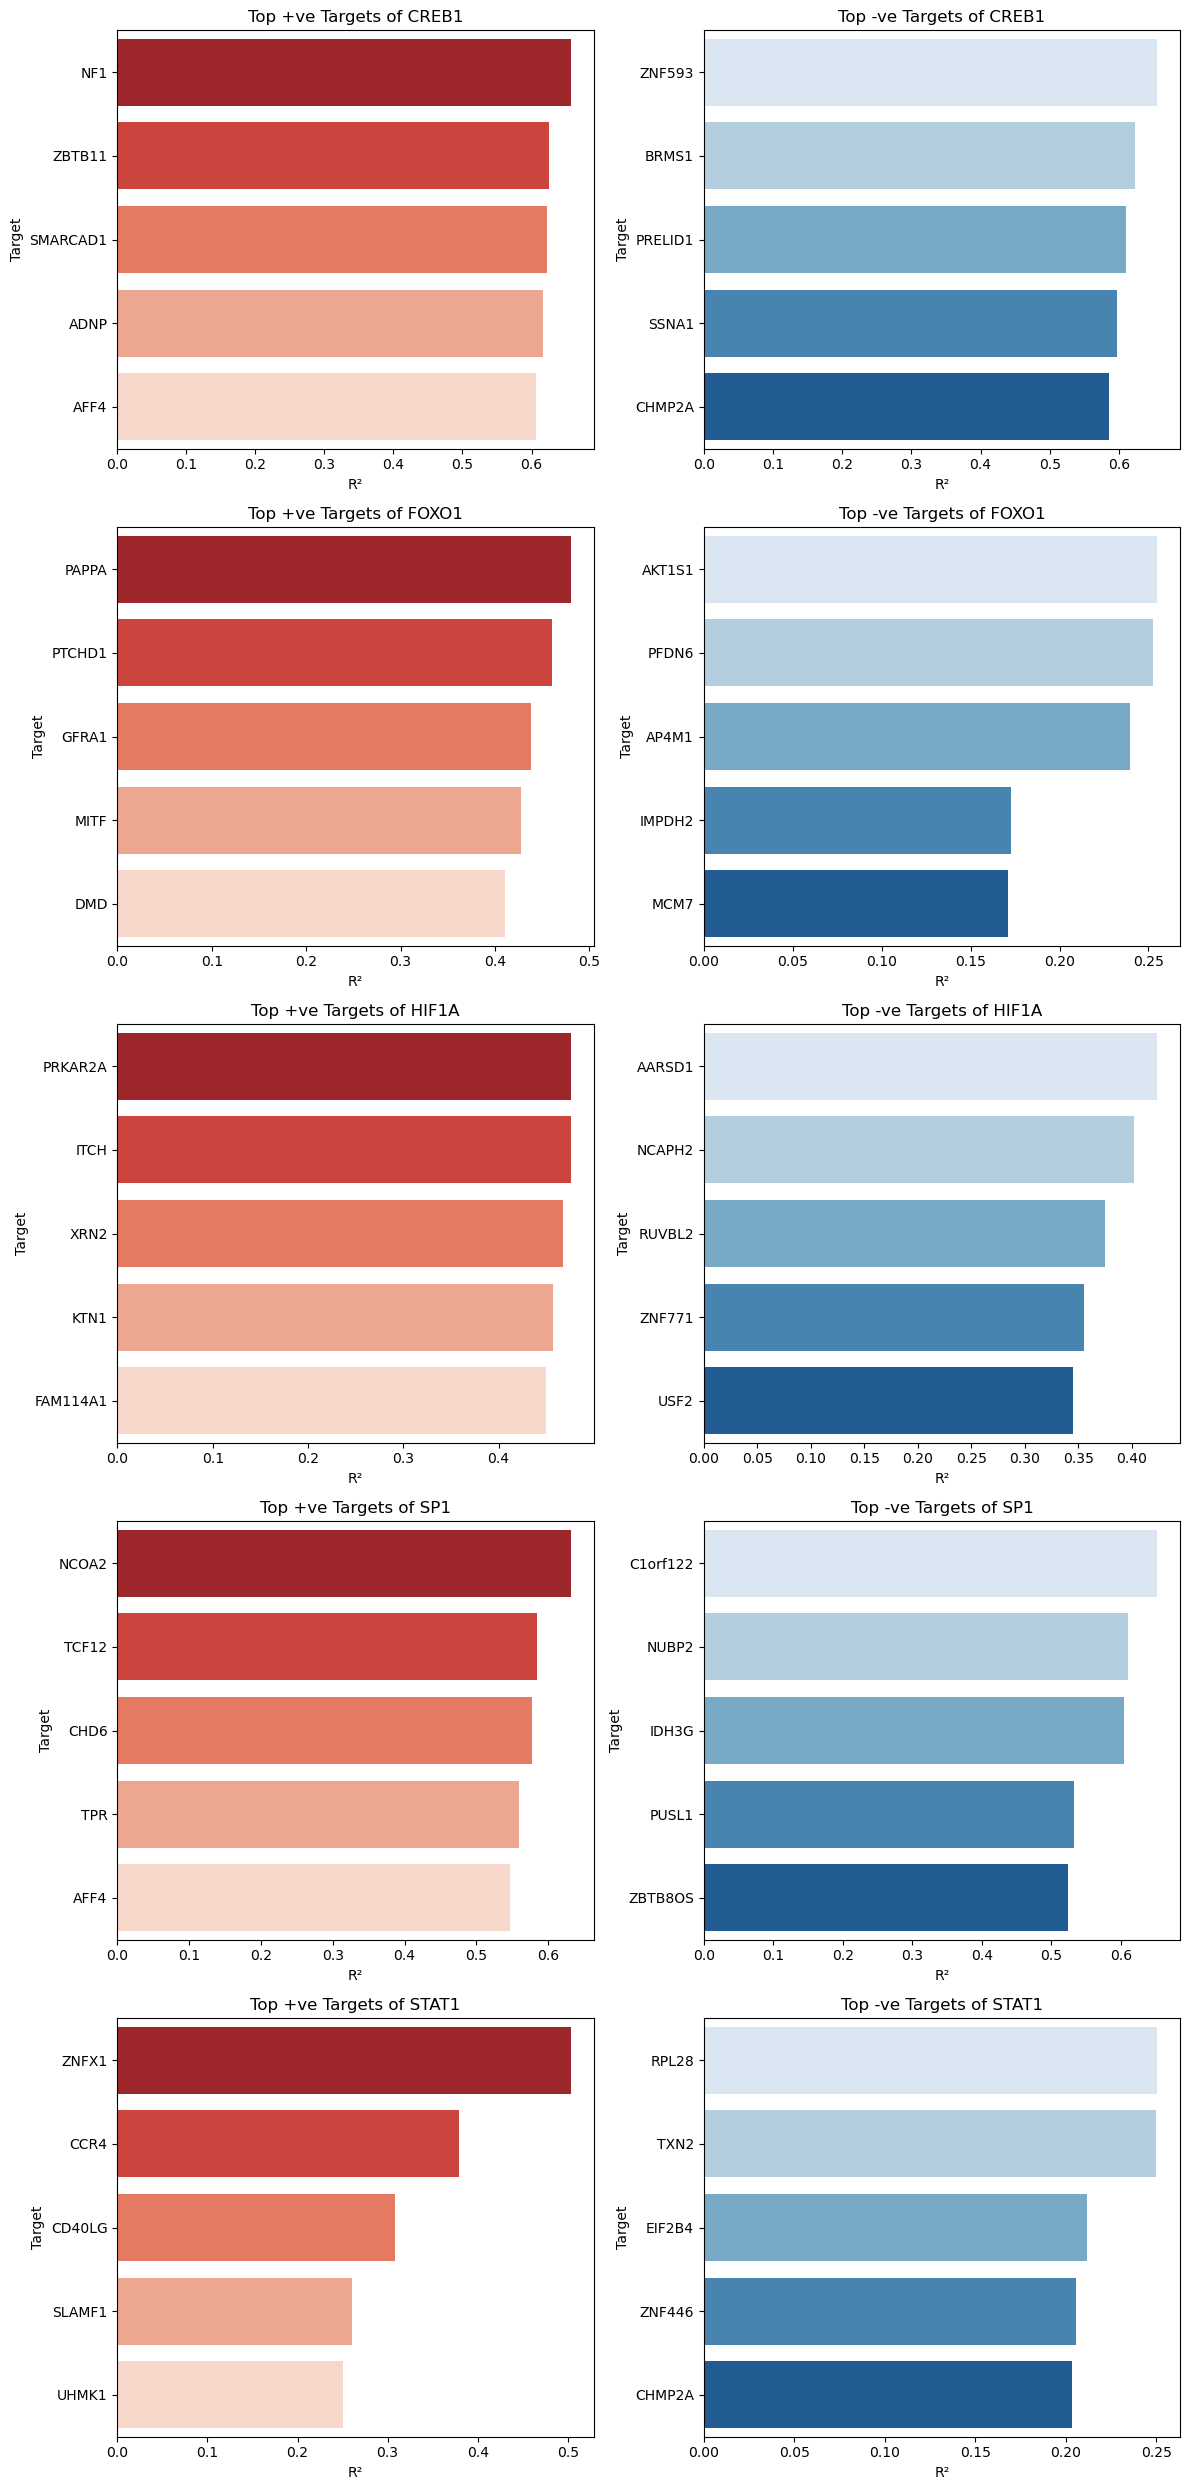

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import os

def load_expression_data(file_path):
    print(f"Loading expression data from {file_path}...")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    expr_df = pd.read_csv(file_path, index_col=0)
    print(f"Loaded data dimensions: {expr_df.shape}")
    expr_df = expr_df.dropna()
    return expr_df

def load_all_tfs(file_path):
    print(f"Loading all TFs from {file_path}...")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    tfs_df = pd.read_csv(file_path)
    return list(tfs_df['TF'])

def preprocess_expression_data(expr_df):
    if expr_df.mean().mean() > 50:
        expr_df = np.log2(expr_df + 1)
    expr_normalized = expr_df.T.apply(lambda x: (x - x.mean()) / x.std(), raw=True).T
    return expr_normalized

def perform_regression_analysis(expr_df, tfs, p_threshold=0.05, r2_threshold=0.1):
    print("Starting regression analysis...")
    results = []
    available_tfs = [tf for tf in tfs if tf in expr_df.index]
    if not available_tfs:
        return pd.DataFrame(), pd.DataFrame()
    tf_expr = expr_df.loc[available_tfs]
    for tf in tf_expr.index:
        for gene in expr_df.index:
            if gene == tf:
                continue
            X = sm.add_constant(tf_expr.loc[tf])
            y = expr_df.loc[gene]
            try:
                model = sm.OLS(y, X).fit()
                results.append({
                    'TF': tf,
                    'Target': gene,
                    'Coefficient': model.params.iloc[1],
                    'P_value': model.pvalues.iloc[1],
                    'R_squared': model.rsquared
                })
            except:
                continue
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        _, corrected_pvals, _, _ = multipletests(results_df['P_value'], method='fdr_bh')
        results_df['Adjusted_P_value'] = corrected_pvals
        significant_results = results_df[(results_df['Adjusted_P_value'] < p_threshold) & 
                                         (results_df['R_squared'] > r2_threshold)]
        return results_df, significant_results
    return results_df, pd.DataFrame()

def load_known_tf_targets(file_path):
    print(f"Loading known TF-target relationships from {file_path}...")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    known_tf_tg_df = pd.read_csv(file_path)
    return set(zip(known_tf_tg_df['TF'], known_tf_tg_df['Target']))

def filter_known_relationships(significant_results, known_tf_tg):
    intersection = significant_results[
        significant_results.apply(lambda row: (row['TF'], row['Target']) in known_tf_tg, axis=1)
    ]
    return intersection

def visualize_intersection(filtered_results, top_n=20):
    if filtered_results.empty:
        print("No known relationships to visualize.")
        return
    half_n = top_n // 2
    top_positive = filtered_results[filtered_results['Coefficient'] > 0].nlargest(half_n, 'Coefficient')
    top_negative = filtered_results[filtered_results['Coefficient'] < 0].nsmallest(half_n, 'Coefficient')
    top_filtered = pd.concat([top_positive, top_negative])
    colors = ['red' if c > 0 else 'blue' for c in top_filtered['Coefficient']]
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y=top_filtered['TF'] + ' → ' + top_filtered['Target'], 
                data=top_filtered, palette=colors)
    plt.title(f'Top {top_n} Known TF-Target Relationships (Positive & Negative)')
    plt.tight_layout()
    plt.savefig('known_tf_target_relationships.png')
    print("Saved known_tf_target_relationships.png")

def display_top_targets_per_tf(filtered_results, top_n=5):
    if filtered_results.empty:
        print("No known relationships to display.")
        return
    print("Top target genes per TF:")
    grouped = filtered_results.groupby('TF')
    for tf, group in grouped:
        top_targets = group.sort_values(by='R_squared', ascending=False).head(top_n)
        print(f"\n{tf}:")
        for _, row in top_targets.iterrows():
            print(f"  - {row['Target']} (R²={row['R_squared']:.3f}, Coef={row['Coefficient']:.3f})")

def plot_top_targets_per_tf(filtered_results, top_n=5):
    if filtered_results.empty:
        print("No known relationships to plot.")
        return
    grouped = filtered_results.groupby('TF')
    n_tfs = len(grouped)
    n_cols = 2
    n_rows = n_tfs
    plt.figure(figsize=(12, 5 * n_rows))
    for i, (tf, group) in enumerate(grouped):
        pos_targets = group[group['Coefficient'] > 0].sort_values(by='R_squared', ascending=False).head(top_n)
        neg_targets = group[group['Coefficient'] < 0].sort_values(by='R_squared', ascending=False).head(top_n)

        plt.subplot(n_tfs, 2, 2 * i + 1)
        sns.barplot(data=pos_targets, x='R_squared', y='Target', palette='Reds_r')
        plt.title(f"Top +ve Targets of {tf}")
        plt.xlabel('R²')

        plt.subplot(n_tfs, 2, 2 * i + 2)
        sns.barplot(data=neg_targets, x='R_squared', y='Target', palette='Blues')
        plt.title(f"Top -ve Targets of {tf}")
        plt.xlabel('R²')

    plt.tight_layout()
    plt.savefig("top_pos_neg_targets_per_tf.png")
    print("Saved top_pos_neg_targets_per_tf.png")

def main():
    expression_file = "C:/Users/sanis/OneDrive/Desktop/Sem 8/Genomic Data Analysis/project/data.csv"
    tfs_file = "C:/Users/sanis/OneDrive/Desktop/Sem 8/Genomic Data Analysis/project/all_tfs.csv"
    known_tf_tg_file = "C:/Users/sanis/OneDrive/Desktop/Sem 8/Genomic Data Analysis/project/known_tf_targets.csv"
    expr_df = load_expression_data(expression_file)
    tfs = load_all_tfs(tfs_file)
    expr_normalized = preprocess_expression_data(expr_df)
    all_results, significant_results = perform_regression_analysis(
        expr_normalized, tfs, p_threshold=0.05, r2_threshold=0.1
    )
    known_tf_tg = load_known_tf_targets(known_tf_tg_file)
    filtered_results = filter_known_relationships(significant_results, known_tf_tg)
    visualize_intersection(filtered_results)
    display_top_targets_per_tf(filtered_results, top_n=5)
    plot_top_targets_per_tf(filtered_results, top_n=5)
    print("Analysis complete!")

if __name__ == "__main__":
    main()
